In [20]:
import os
import tempfile
# For N-dimensional array manipulation
import numpy as np
# Plotting library
import matplotlib.pyplot as plt
# For data analysis and data structures in DataFrames
import pandas as pd
# For data visualization
import seaborn as sns

# For machine learning algorithms and evaluation metrics
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

#import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [21]:
# Load dataset
df = pd.read_csv('./media_bias.csv')

# Clean dataset
df = df[df.Label_bias != 'No agreement']
df = df[df.article != 'NaN']
df = df[df.sentence != 'NaN']

# Replace label with 0, 1
df['Label_bias'] = df['Label_bias'].replace('Biased', 1)
df['Label_bias'] = df['Label_bias'].replace('Non-biased', 0)

# Only use sentence column and bias column
df = df[['sentence', 'Label_bias', 'type', 'outlet']]
df = df.rename(columns={'sentence': 'text', 'Label_bias': 'label'})

# Remove numbers from all strings in text
df['text'] = df['text'].str.replace('\d+', '', regex=True)

# # Remove punctuation from all strings in X
df['text'] = df['text'].str.replace('[^\w\s]','',regex=True)

# Split data into X and y
X = df[['text','type', 'outlet']]
print(X.head)
y = df['label']

<bound method NDFrame.head of                                                    text    type      outlet
0     YouTube is making clear there will be no birth...  center   usa-today
1     The increasingly bitter dispute between Americ...    left       msnbc
2     So while there may be a humanitarian crisis dr...    left    alternet
3     A professor who teaches climate change classes...   right   breitbart
4     Looking around the United States there is neve...   right  federalist
...                                                 ...     ...         ...
1695  In every case legislators are being swarmed by...    left    alternet
1696  Polls show the transgender ideology is deeply ...   right   breitbart
1697  Democrats and Republicans stood and applauded ...  center   usa-today
1698  As a selfdescribed Democratic socialist Sen Be...   right    fox-news
1699  During the segment Colbert also bemoaned the f...   right   breitbart

[1551 rows x 3 columns]>


In [22]:
#Split df into training and testing sets
train, test = train_test_split(df, test_size=0.1, random_state=42)

In [23]:
%pip install -q transformers

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Note: you may need to restart the kernel to use updated packages.


In [24]:
def convert_example_to_feature(entry, max_length=512):
  return tokenizer.encode_plus(entry,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [38]:
batch_size = 16

In [39]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [40]:
def encode_entries(ds, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  print(ds)
  for text, label, type, outlet in ds.to_numpy():
    bert_input = convert_example_to_feature(text)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [41]:
# train dataset
training_encoded = encode_entries(train).shuffle(100).batch(batch_size)
# test dataset
testing_encoded = encode_entries(test).batch(batch_size)

                                                   text  label    type  \
1274  Warrens speech included leftist talking points...      1   right   
1072  He justified his racism by saying that many pe...      1    left   
599   This is how Warren has pushed the boundaries o...      1    left   
1220  They found that many disadvantaged white stude...      1   right   
1378  Trump appeared to be referring to Northams sig...      0  center   
...                                                 ...    ...     ...   
1253  He even wants a son to get a background check ...      0   right   
1428  South Bend Mayor Pete Buttigieg a Democratic c...      1    left   
949   Hundreds of white nationalists lined the stree...      0    left   
1601  However there is evidence suggesting that havi...      1    left   
1249  It may have taken Trump to point out the pitfa...      1    left   

          outlet  
1274   breitbart  
1072    alternet  
599     huffpost  
1220  federalist  
1378   usa-today

c:\Users\verni\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


                                                   text  label    type  \
1666  Spencer speculated that the media may be soull...      1    left   
683   Officials at Dartmouth College looked the othe...      1   right   
385   As the worlds scientists and pharmaceutical co...      1  center   
386   Though it was Major League Baseball that he me...      1    left   
561   The fact that the abortion rate among American...      1   right   
...                                                 ...    ...     ...   
1173  Two Democrats  state Sens Creigh Deeds and Cha...      0   right   
526   The government of the secretive central Asian ...      1   right   
1284  The Labour politician who has presided over an...      0   right   
46    Abortion propaganda was always meant to obscur...      1   right   
1033  And yes theres something in the Fox News DNA o...      1    left   

          outlet  
1666       msnbc  
683    breitbart  
385      reuters  
386     alternet  
561   federalist

c:\Users\verni\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
from transformers import TFBertForSequenceClassification
learning_rate = 2e-5
number_of_epochs = 3
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#Add layers to model for fine tuning BERT for classification
# model = tf.keras.Sequential([
#     model,
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()


Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [44]:
bert_history = model.fit(training_encoded, epochs=number_of_epochs, validation_data=testing_encoded)

Epoch 1/3
 9/88 [==>...........................] - ETA: 1:19:56 - loss: 0.6453 - accuracy: 0.6597

In [13]:
# Test the model
test_loss, test_acc = model.evaluate(testing_encoded)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

52/52 [==============================] - 216s 4s/step - loss: 0.4978 - accuracy: 0.7814
Test Loss: 0.497801274061203
Test Accuracy: 0.7813504934310913


In [101]:
inputs = tokenizer("This is a fact which is better than fiction", return_tensors="tf")

logits = model(**inputs).logits

print(logits)
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
print(predicted_class_id)

tf.Tensor([[0.11597355 0.34613058]], shape=(1, 2), dtype=float32)
1


In [59]:
tf.config.run_functions_eagerly(True)

In [84]:
# Show heatmap of test data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

y_pred = model.predict(testing_encoded)

52/52 [==============================] - 256s 5s/step


TFSequenceClassifierOutput(loss=None, logits=array([[0.2621841 , 0.3345329 ],
       [0.36097503, 0.33989993],
       [0.3079635 , 0.32566267],
       [0.2749032 , 0.29687908],
       [0.32643008, 0.2706525 ],
       [0.19728915, 0.28907388],
       [0.23566322, 0.25392088],
       [0.34717909, 0.28714693],
       [0.22256082, 0.3077171 ],
       [0.39117917, 0.1147105 ],
       [0.4708222 , 0.26538128],
       [0.32113147, 0.30149934],
       [0.34965557, 0.21689668],
       [0.3226074 , 0.27152953],
       [0.2737127 , 0.27840298],
       [0.4043406 , 0.25710952],
       [0.37805668, 0.18697849],
       [0.35098964, 0.18351164],
       [0.40169805, 0.38554335],
       [0.34833562, 0.21514097],
       [0.33065322, 0.27803507],
       [0.38799366, 0.40345043],
       [0.31802678, 0.22712913],
       [0.35332343, 0.2715444 ],
       [0.40313125, 0.21176654],
       [0.34190196, 0.35529914],
       [0.37850195, 0.06409124],
       [0.37653607, 0.24923772],
       [0.3378402 , 0.21933296]

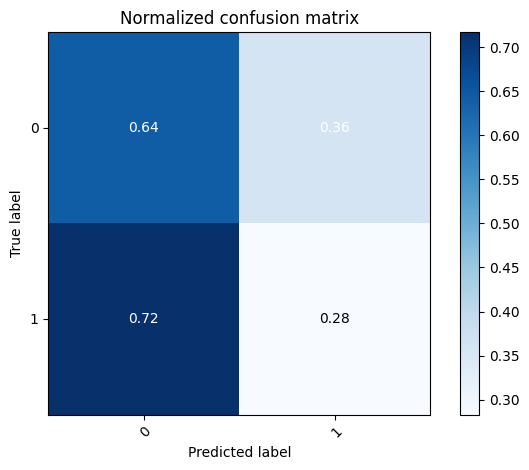

In [100]:
print(y_pred)
y_pred_bool = np.argmax(y_pred[0], axis=1)
print(y_pred_bool)
plot_confusion_matrix(test['label'], y_pred_bool, classes=['0', '1'], normalize=True, title='Normalized confusion matrix')
plt.show()


In [121]:
# Create keras prediction function
tf.data.experimental.enable_debug_mode()
# predictionInput = pd.DataFrame(["The president is a big fat liar.", "This a is a factual bit of text."], columns=['sentence'])
predictionInput = ["YouTube is making clear there will be no “birtherism” on its platform during this year’s U.S. presidential election – a belated response to a type of conspiracy theory more prevalent in the 2012 race."]
print(predictionInput)
MAX_LEN = 10
classes = ['non-biased', 'biased']

def keras_predict(model, tokenizer, sentence):
    encoded_sentence = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=512, padding=False, return_attention_mask=True, return_tensors='tf')
    input_ids = encoded_sentence['input_ids']
    attention_masks = encoded_sentence['attention_mask']
    token_type_ids = encoded_sentence['token_type_ids']
    prediction = model.predict([input_ids, attention_masks, token_type_ids])
    return prediction

prediction = keras_predict(model, tokenizer, predictionInput)
print((prediction[0][0]))
print(np.argmax(prediction[0][0]))


['YouTube is making clear there will be no “birtherism” on its platform during this year’s U.S. presidential election – a belated response to a type of conspiracy theory more prevalent in the 2012 race.']
1/1 [==============================] - 0s 232ms/step
[0.1783105 0.2375525]
1


In [125]:


predictionInput = pd.DataFrame(["The president is a big fat liar.", "This a is a factual bit of text."], columns=['sentence'])
print(predictionInput)
MAX_LEN = 10
classes = ['non-biased', 'biased']
pred = []
for entry in predictionInput['sentence']:
  encoded_sentence = tokenizer.encode_plus(entry, add_special_tokens=True, max_length=512, padding=False, return_attention_mask=True, return_tensors='tf')
  input_ids = encoded_sentence['input_ids']
  attention_masks = encoded_sentence['attention_mask']
  token_type_ids = encoded_sentence['token_type_ids']
  prediction = model.predict([input_ids, attention_masks, token_type_ids])
  pred.append(np.argmax(prediction[0][0]))
  # Get keras tensor attention mask and input ids


print(pred)


                           sentence
0  The president is a big fat liar.
1  This a is a factual bit of text.
1/1 [==============================] - 0s 229ms/step
[0, 1]
